# What relationship can we derive when comparing groundwater quality data with drinking water quality? 

The aim of this investigation is to build a classification model to quantify the association between groundwater monitoring results from the Groundwater Ambient Monitoring and Assessment (GAMA) and the California Dept of Public Health's drinking water quality results (DDW). For a classification model such as this, I would rely on the confusion matrix to evaluate the model’s performance. Since detection of contamination in a system’s supply is a matter of public health, optimization should be geared towards sensitivity.

This notebook contains the code for modeling on the data extracted and munged from the preceeding notebook "Capstone_Import_EDA".


## Library Imports

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

# Evaluation
from sklearn.metrics import confusion_matrix

## Import Data

In [2]:
df = pd.read_csv('./abt.csv')
print(df.shape)
df.head()

(1237, 16)


,Unnamed: 0,new_id,LOGDATE,ALPHA,AS,F,NO3,TCE,U,NITRATE (AS NO3),GROSS ALPHA,ARSENIC,FLUORIDE (F) (NATURAL-SOURCE),PERCHLORATE,URANIUM (PCI/L),URANIUM MDA95
0,0,GAOG10009209 07B01,2017-06-08,0.55,0.0,0.0,42.0,0.0,0.016,0,0,0,0,0,0,0
1,1,GAOG10009209 07B01,2017-10-05,19.00,0.0,0.0,59.0,0.0,0.023,0,0,1,0,0,0,0
2,2,GAOG10009209 07B01,2018-03-20,14.00,0.0,0.0,51.0,0.0,0.023,0,0,1,0,0,0,0
3,3,GAOG10009209 15E01,2017-06-07,16.00,0.0,0.0,0.0,0.0,0.020,0,0,0,0,0,0,0
4,4,GAOG10009209 15E01,2017-10-04,6.70,0.0,0.0,0.0,0.0,0.021,0,0,0,0,0,1,0


In [3]:
# Rename columns for better management

names = {'new_id': 'new_id',
         'LOGDATE': 'date',
         'ALPHA': 'gw_alpha',
         'AS': 'gw_as',
         'F': 'gw_f',
         'NO3': 'gw_no3',
         'TCE': 'gw_tce',
         'U': 'gw_u',
         'NITRATE (AS NO3)': 'no3',
         'GROSS ALPHA': 'alpha',
         'ARSENIC': 'as',
         'FLUORIDE (F) (NATURAL-SOURCE)': 'f',
         'PERCHLORATE': 'perc',
         'URANIUM (PCI/L)': 'u',
         'URANIUM MDA95': 'u_other'}

df.rename(columns=names, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gw_alpha,1237.0,2.860399,21.248745,-28.8,0.0,0.0,0.0,290.0
gw_as,1237.0,5.412848,54.170673,0.0,0.0,0.0,0.0,680.0
gw_f,1237.0,0.035959,0.290254,0.0,0.0,0.0,0.0,6.6
gw_no3,1237.0,2.473808,23.189962,0.0,0.0,0.0,0.0,610.0
gw_tce,1237.0,0.004867,0.106025,0.0,0.0,0.0,0.0,3.3
gw_u,1237.0,1.292042,9.364264,0.0,0.0,0.0,0.0,110.0
no3,1237.0,0.054972,0.228017,0.0,0.0,0.0,0.0,1.0
alpha,1237.0,0.025869,0.158809,0.0,0.0,0.0,0.0,1.0
as,1237.0,0.218270,0.413239,0.0,0.0,0.0,0.0,1.0
f,1237.0,0.001617,0.040193,0.0,0.0,0.0,0.0,1.0


In [5]:
target = ['no3', 'alpha', 'as', 'f', 'perc', 'u', 'u_other']

for analyte in target:
    print(df[analyte].value_counts())
    print('Baseline %: ', df[analyte].value_counts()[1]/1237*100)
    print('')

0    1169
1      68
Name: no3, dtype: int64
Baseline %:  5.497170573969281

0    1205
1      32
Name: alpha, dtype: int64
Baseline %:  2.5869037995149555

0    967
1    270
Name: as, dtype: int64
Baseline %:  21.827000808407437

0    1235
1       2
Name: f, dtype: int64
Baseline %:  0.16168148746968472

0    1220
1      17
Name: perc, dtype: int64
Baseline %:  1.3742926434923202

0    1177
1      60
Name: u, dtype: int64
Baseline %:  4.8504446240905414

0    1222
1      15
Name: u_other, dtype: int64
Baseline %:  1.2126111560226354



Given the extreme sparsity of Fluoride, I will not be able to properly build a model that could classify it with much success. So for this initial model, I will exclude it from modeling and analysis.

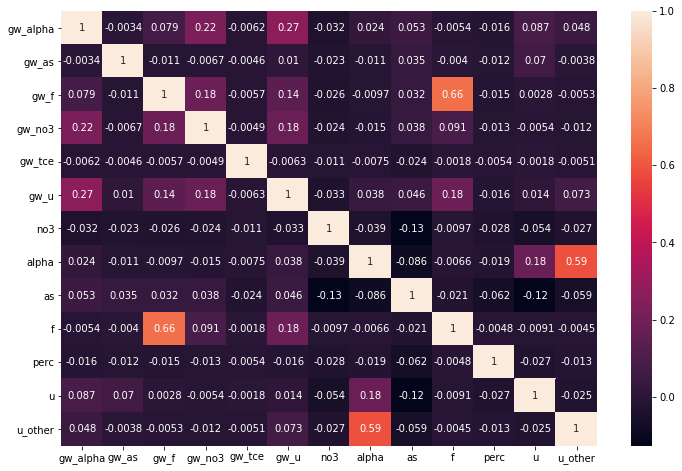

In [6]:
plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), annot=True);

Pretty low correlation across the board for groundwater levels of arsenic and tetrachloroethylene, while drinking water isn't much affected by nitrate, arsenic or perchlorate. The only moderately correlated between drinking water and groundwater is fluoride, and very weakly correlated between radionuclides amongst the respective sources, though it makes sense as those contaminants are related.

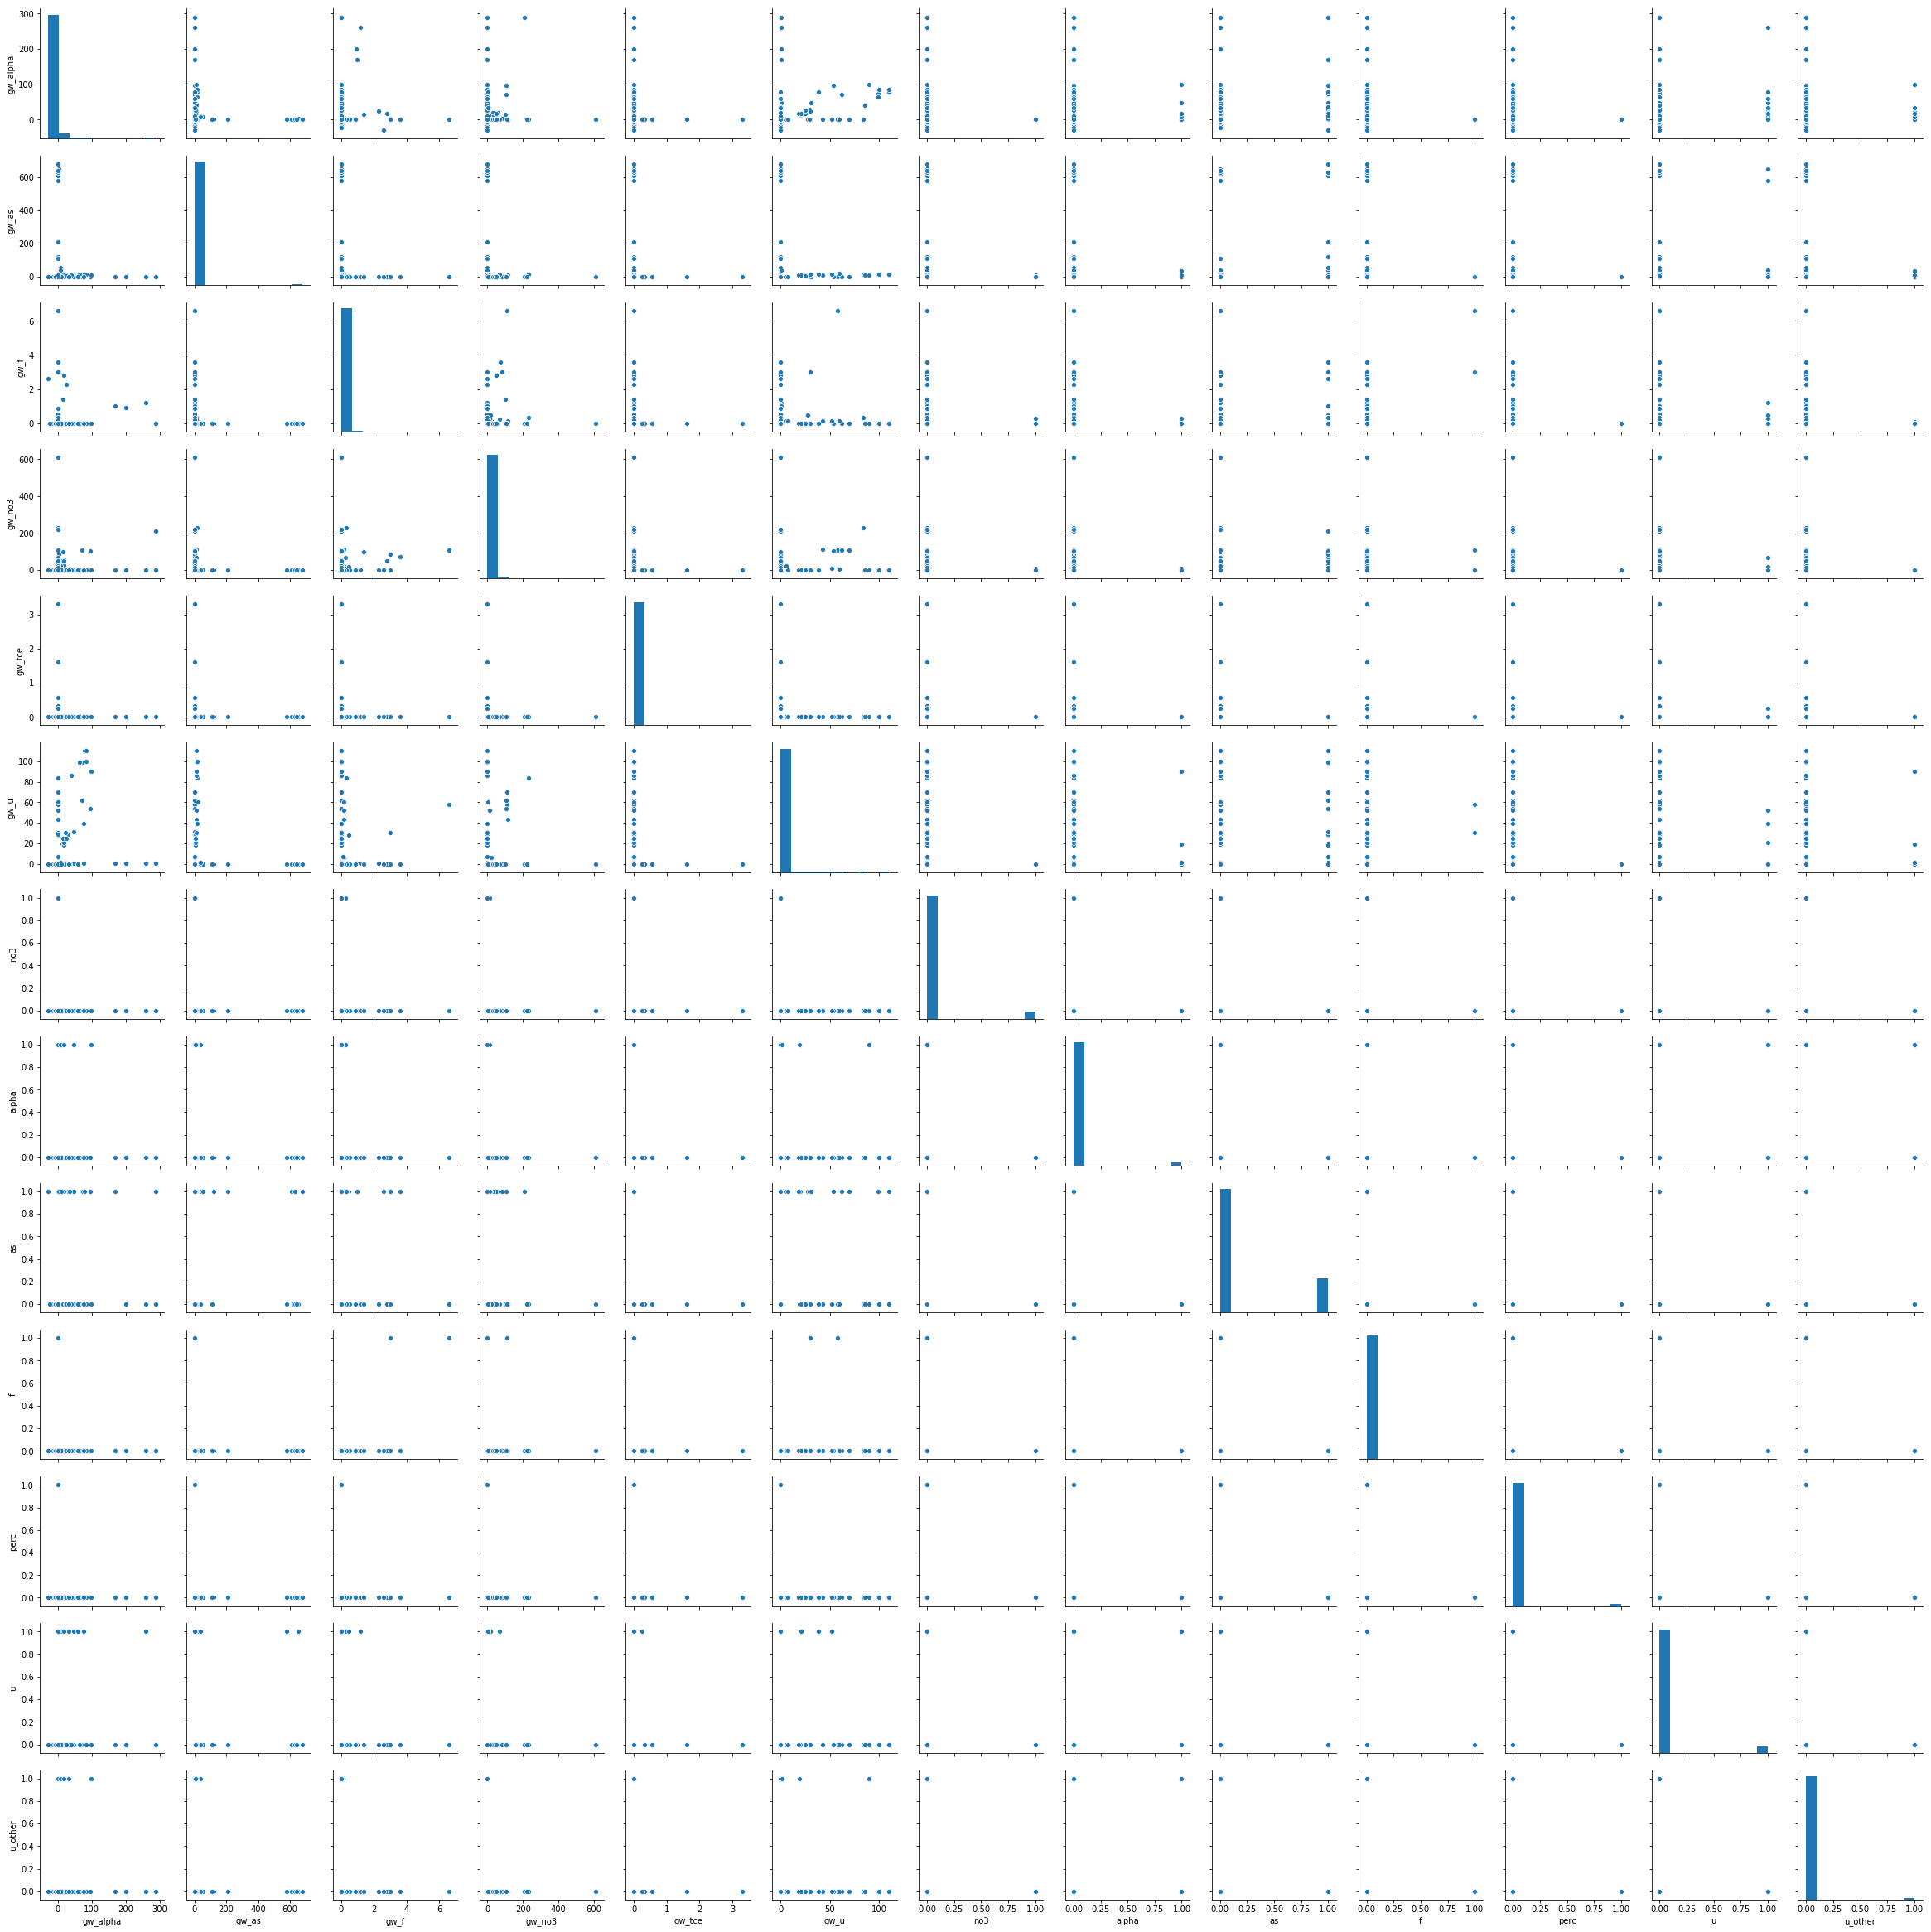

In [7]:
sns.pairplot(df);

## Test Train Split

In [8]:
features = ['gw_alpha', 'gw_as', 'gw_f', 'gw_no3', 'gw_tce', 'gw_u']
classes = ['no3', 'alpha', 'as', 'perc', 'u', 'u_other']

X = df[features]
y = df[classes]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [9]:
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
no3,927.0,0.055016,0.228135,0.0,0.0,0.0,0.0,1.0
alpha,927.0,0.025890,0.158893,0.0,0.0,0.0,0.0,1.0
as,927.0,0.217907,0.413047,0.0,0.0,0.0,0.0,1.0
perc,927.0,0.014024,0.117652,0.0,0.0,0.0,0.0,1.0
u,927.0,0.048544,0.215028,0.0,0.0,0.0,0.0,1.0
u_other,927.0,0.012945,0.113098,0.0,0.0,0.0,0.0,1.0


In [16]:
y_test['as'].value_counts()

0    242
1     68
Name: as, dtype: int64

## Modeling

The nature of this problem is not simply one of mutually exclusive classification. A sample of drinking water can have more than one contaminant detected above its maximum limit. Therefore, limiting model selection to the following: Decision Trees, Random Forests, and Logistic Regression. As such, each contaminant should be modeled separately.

There is a significant geospatial and temporal correlation element to the data and while I am aware of it, for the sake of deadline deliverables I am choosing to treat all sampling data as a snapshot and limiting. These are certainly broader, more technically rigorous modeling should be explored at a later time.

### Decision Tree

This model was chosen for baseline simplicity and readability.

In [10]:
# Empty dictionary to store models
dt_fit_models = {}
    
for analyte in classes:
    
    # Instantiate Model
    dt = DecisionTreeClassifier()
    
    # Fit and store
    dt_model = dt.fit(X_train, y_train[analyte])   
    dt_fit_models[analyte] = dt_model

    #Score 
    dt_score = cross_val_score(dt_model, X_train, y_train[analyte], cv=5)
    
    # Predict
    predictions = dt.predict(X_test)
    
    # Print Accuracy Results
    print(analyte)
    print('Training accuracy: ', round(dt_score.mean(),4))
    print('Test accuracy:     ', round(dt.score(X_test, y_test[analyte]),4))
    
    # Print Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test[analyte], predictions).ravel()
    print('True Negatives: ', tn)
    print('False Positives: ', fp)
    print('False Negatives: ', fn)
    print('True Positives: ', tp)
    
    print('')

no3
Training accuracy:  0.9439
Test accuracy:      0.9452
True Negatives:  293
False Positives:  0
False Negatives:  17
True Positives:  0

alpha
Training accuracy:  0.9676
Test accuracy:      0.9613
True Negatives:  298
False Positives:  4
False Negatives:  8
True Positives:  0

as
Training accuracy:  0.7832
Test accuracy:      0.8032
True Negatives:  236
False Positives:  6
False Negatives:  55
True Positives:  13

perc
Training accuracy:  0.986
Test accuracy:      0.9871
True Negatives:  306
False Positives:  0
False Negatives:  4
True Positives:  0

u
Training accuracy:  0.9407
Test accuracy:      0.9387
True Negatives:  290
False Positives:  5
False Negatives:  14
True Positives:  1

u_other
Training accuracy:  0.9795
Test accuracy:      0.9839
True Negatives:  305
False Positives:  2
False Negatives:  3
True Positives:  0



### Evaluation Notes:

The Decision Tree Classifier with all default settings performed with a training accuracy between $78.3$% - $98.6$% and a testing accuracy between $79.6$% - $98.7$% accross all contaminants detected over MCL. While the accuracy may look impressive on Nitrate, Alpha radiation, Perchlorate, and both measures of Uranium, the confusion matrix tells a different story. The Decision Tree model was only able to classify 12 true positives for Arsenic and next to none for each of the other contaminants. What is most concerning are false negatives here, 56 in the case of Arsenic, as these represent contaminated water sent to a treatment plant having been initially believed to be clean.

### Attempt to improve precision on Arsenic classification by oversampling

The model suffers a lot from imbalanced classes. Using the SMOTE algorithm (Synthetic Minority Oversampling Technique) to create synthetic observations of the minority class, in this case Arsenic because it is the least unbalanced and fewer sythetic observations would be created to balance it.

In [11]:
# Oversampling
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(np.array(X_train), np.array(y_train['as']))

In [12]:
# Instantiate a separate Decision Tree Model
dtree_res = DecisionTreeClassifier(random_state=42)

# Fit
dtree_res.fit(X_train_res, y_train_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [13]:
# Scoring on the unbalanced training data
dtree_res__tr_score = cross_val_score(dtree_res, X_train, y_train)
dtree_res_te_score = dtree_res.score(X_test, y_test['as'])
print('Training accuracy: ', round(dtree_res__tr_score.mean(), 4))
print('Test accuracy:     ', round(dtree_res_te_score,4))

# Predict
pred = dtree_res.predict(X_test)

# Print Evaluation Results
dtree_cm = confusion_matrix(y_test['as'], pred)
tn_res, fp_res, fn_res, tp_res = dtree_cm.ravel()

print('True Negatives: ', tn_res)
print('False Positives: ', fp_res)
print('False Negatives: ', fn_res)
print('True Positives: ', tp_res)

Training accuracy:  0.6505
Test accuracy:      0.7871
True Negatives:  231
False Positives:  11
False Negatives:  55
True Positives:  13


C:\Users\Nicole\Anaconda3\envs\dsi\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


### Visualization of Decision Tree

In [15]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

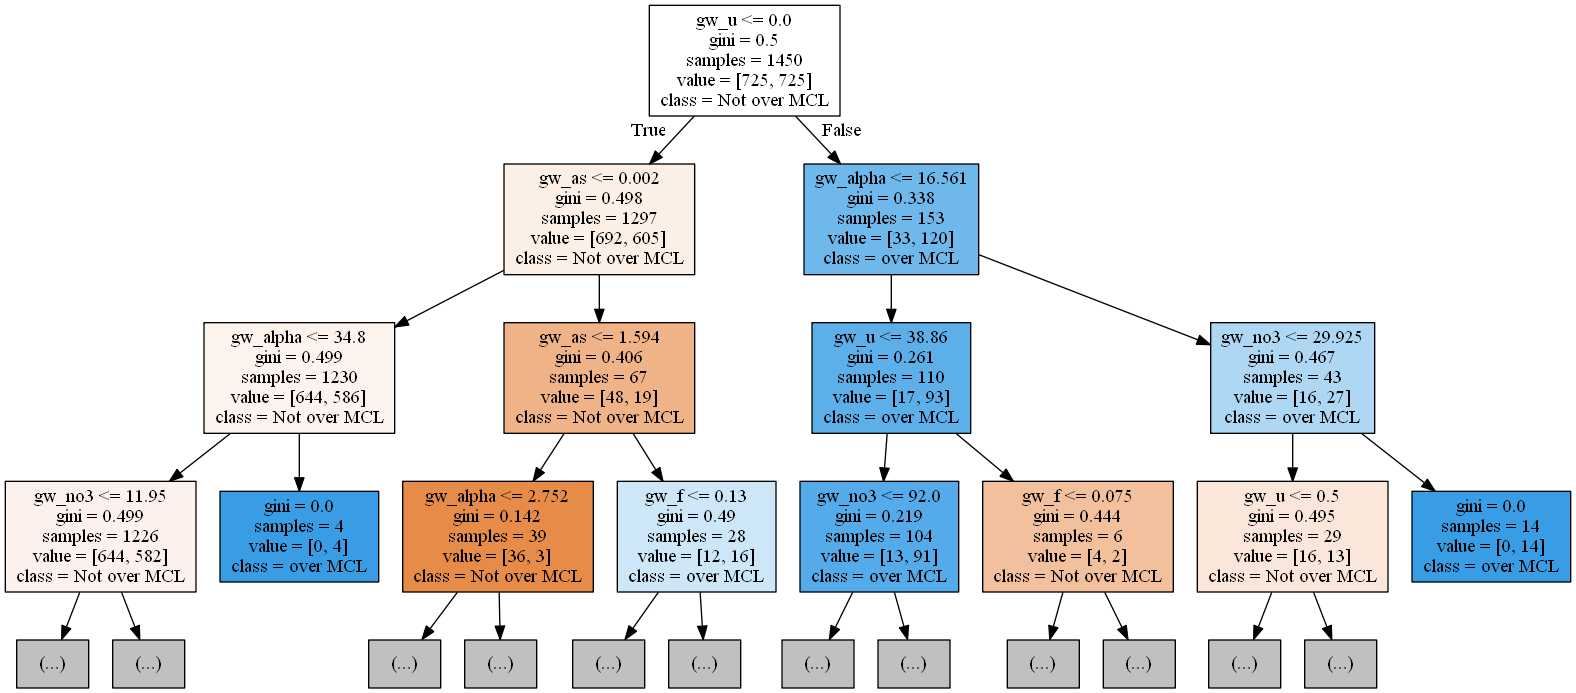

In [26]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
export_graphviz(dtree_res, out_file=dot_data, 
                feature_names=X_train.columns, class_names=['Not over MCL', 'over MCL'], 
                filled=True, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Evaluation Notes:

Performing oversampling did not yield very much improvement in terms of either accuracy or decreasing false negatives. It only gained 1 true positive and 3 false positives, while eliminating the corresponding false negatives and true positives.

In [135]:
dt_feature_importance = pd.DataFrame(index = X.columns, data = dtree_res.feature_importances_, 
                                     columns=['Importance']).sort_values('Importance', ascending=False)
dt_feature_importance

,Importance
gw_u,0.340532
gw_alpha,0.240533
gw_f,0.153015
gw_as,0.151598
gw_no3,0.102321
gw_tce,0.012002


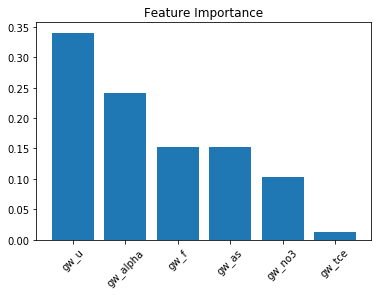

In [137]:
indices = np.argsort(dtree_res.feature_importances_)[::-1]
names = [X.columns[i] for i in indices]

# Creating a boxplot visualization of Feature Importance
plt.figure()

plt.bar(range(X.shape[1]), dtree_res.feature_importances_[indices])

plt.xticks(range(X.shape[1]), names, rotation=45)

plt.title('Feature Importance');

### Feature Importance

This shows a bar graph of the groundwater features by descending importance based on gini-purity. The measure of uranium in groundwater played the most important role on how the Decision Tree model would split the data on a given node.

### Random Forest Classification

This model builds on the baseline of the Decision Tree model, adding a bootstrapping element to the sparse classes in order to enhance accuracy.

In [138]:
rf_fit_models = {}

for analyte in classes:
    
    # Instantiate Model
    rf = RandomForestClassifier(random_state=42)
    
    # Fit and store
    rf_model = rf.fit(X_train, y_train[analyte])
    rf_fit_models[analyte] = rf_model


    # Predict and score
    predictions = rf.predict(X_test)
    rf_score = cross_val_score(rf_model, X_train, y_train[analyte], cv=5)
    
    
    # Print Accuracy Results
    print(analyte)
    print('Training accuracy: ', round(rf_score.mean(),3))
    print('Test accuracy:     ', round(rf.score(X_test, y_test[analyte]),3))
    
    # Print Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test[analyte], predictions).ravel()
    print('True Negatives: ', tn)
    print('False Positives: ', fp)
    print('False Negatives: ', fn)
    print('True Positives: ', tp)
    
    print('')

C:\Users\Nicole\Anaconda3\envs\dsi\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Nicole\Anaconda3\envs\dsi\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Nicole\Anaconda3\envs\dsi\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Nicole\Anaconda3\envs\dsi\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


no3
Training accuracy:  0.945
Test accuracy:      0.945
True Negatives:  293
False Positives:  0
False Negatives:  17
True Positives:  0

alpha
Training accuracy:  0.976
Test accuracy:      0.971
True Negatives:  301
False Positives:  1
False Negatives:  8
True Positives:  0

as
Training accuracy:  0.781
Test accuracy:      0.797
True Negatives:  238
False Positives:  4
False Negatives:  59
True Positives:  9

perc
Training accuracy:  0.986
Test accuracy:      0.987
True Negatives:  306
False Positives:  0
False Negatives:  4
True Positives:  0

u
Training accuracy:  0.948
Test accuracy:      0.942
True Negatives:  292
False Positives:  3
False Negatives:  15
True Positives:  0

u_other
Training accuracy:  0.988
Test accuracy:      0.99
True Negatives:  307
False Positives:  0
False Negatives:  3
True Positives:  0



C:\Users\Nicole\Anaconda3\envs\dsi\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Nicole\Anaconda3\envs\dsi\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Evaluation Notes:

The Random Forest Classifier with all default settings performed with a training accuracy between $78.1$% - $98.8$% and a testing accuracy between $79.7$% - $99.0$%. Which is nearly identical to the performance of a single Decision Tree. There is less evidence here of overfitting due to the training accuracy being slightly higher than the testing accuracy. However, the confusion matrix also shows that these Random Forest Classifier models also suffer from low true positive rates and not-negligible false negative rates.


In [60]:
rf_feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)
rf_feature_importances

,Importance
gw_alpha,0.312329
gw_u,0.225952
gw_as,0.163990
gw_no3,0.154512
gw_f,0.124605
gw_tce,0.018612


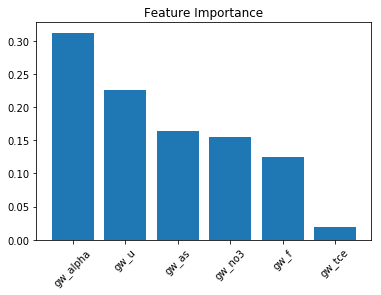

In [61]:
# Visualization of the Feature Importances

indices = np.argsort(rf.feature_importances_)[::-1]
names = [X.columns[i] for i in indices]

# Creating a boxplot visualization of Feature Importance
plt.figure()

plt.bar(range(X.shape[1]), rf.feature_importances_[indices])

plt.xticks(range(X.shape[1]), names, rotation=45)

plt.title('Feature Importance');

### Feature Importance

This shows a bar graph of the groundwater features by descending importance based on gini-purity. The measure of gross alpha in groundwater played the most important role on how the Decision Tree model would split the data on a given node, which looks to be overtaken in importance from the Decision Tree models. In both cases, TCE played little importance.

### Logistic Regression

This model was chosen for its interpretability and its ubiquity in understanding to non-technical audiences. 

In [139]:
lr_fitted_models = {}

for analyte in classes:
    
    # Instantiate Model
    lr = LogisticRegressionCV(cv=3, random_state=42)
    
    # Fit and store
    lr_model = lr.fit(X_train, y_train[analyte])
    lr_fitted_models[analyte] = lr_model

    # Predict and score
    predictions = lr.predict(X_test)
    lr_score = cross_val_score(lr_model, X_train, y_train[analyte], cv=5)
    
    
    # Print Accuracy Results
    print(analyte)
    print('Training accuracy: ', round(lr_score.mean(),3))
    print('Test accuracy:     ', round(lr.score(X_test, y_test[analyte]),3))
    
    # Print Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_test[analyte], predictions).ravel()
    print('True Negatives: ', tn)
    print('False Positives: ', fp)
    print('False Negatives: ', fn)
    print('True Positives: ', tp)
    
    print('')

no3
Training accuracy:  0.945
Test accuracy:      0.945
True Negatives:  293
False Positives:  0
False Negatives:  17
True Positives:  0

alpha
Training accuracy:  0.974
Test accuracy:      0.974
True Negatives:  302
False Positives:  0
False Negatives:  8
True Positives:  0

as
Training accuracy:  0.777
Test accuracy:      0.777
True Negatives:  241
False Positives:  1
False Negatives:  68
True Positives:  0

perc
Training accuracy:  0.986
Test accuracy:      0.987
True Negatives:  306
False Positives:  0
False Negatives:  4
True Positives:  0

u
Training accuracy:  0.951
Test accuracy:      0.952
True Negatives:  295
False Positives:  0
False Negatives:  15
True Positives:  0

u_other
Training accuracy:  0.987
Test accuracy:      0.99
True Negatives:  307
False Positives:  0
False Negatives:  3
True Positives:  0



In [242]:
lr_coef = {}

for name, model in lr_fitted_models.items():
    lr_coef[name] = model.coef_[0].tolist()

beta_coefficients = pd.DataFrame(lr_coef, index=X.columns, columns=lr_coef.keys())
beta_coefficients

,no3,alpha,as,perc,u,u_other
gw_alpha,-0.006003,0.004575,0.004653,-0.002484,0.007863,0.006665
gw_as,-0.004282,-0.001320,0.000860,-0.002313,0.002014,-0.000325
gw_f,-0.000108,-0.000029,0.001042,-0.000040,0.000005,-0.000018
gw_no3,-0.004840,-0.004030,0.002046,-0.002030,-0.003777,-0.003542
gw_tce,-0.000032,-0.000014,-0.000941,-0.000008,-0.000002,-0.000007
gw_u,-0.003662,0.005980,0.006024,-0.001300,0.001038,0.007770


### Evaluation Notes:

The Logistic Regression Classifier with all default settings performed with a training accuracy in the high 70 percentage for Arsenic while all the other chemicals were in the high 90 percentage. This follows the same ranges as the Decision Tree and Random Forest models previous. There is less evidence here of overfitting due to the training accuracy being nearly identical to  the testing accuracy. However, it performed the worst of the models in terms of precision for Arsenic, the least imbalanced class.

The table above is of the Beta Coefficients for each groundwater chemical measurement to drinking water detection over MCL. What is most notable is that for each one microgram per Liter increase of gross alpha counts of radionuclides in groundwater there is a $0.0078$ pCi/L fo Uranium in the nearest drinking water well station. There is also a $0.0077$ increase in units of another method of measuring Uranium in the drinking water for a unit increase Uranium detected in the groundwater. The Beta coefficients are so miniscule as to nearly be negligent or too small to be considered within significant figures.

# Conclusions

While still in its very early formation stages, this project does demonstrate the capacity of one non-expert's ability to extract crude insights into the process of modeling the relationship between ambient groundwater quality and drinking water quality sampling results.

Given each model's accuracy performance and unoptimized state, they are far from being able create any predictions. They do support evidence that they are able to relate the readings of radiological contaminants from groundwater samples to drinking water supply samples, which holds with current understanding.

There are a great number of avenues to revisit in the process of this project to build towards a more rigorous and broader understanding in the relationship of groundwater quality and the effect on drinking water supply, not only starting with Kern County but perhaps even the rest of California.